# Lemmatization using Attention Mechanism

In [2]:
# Import library
import random
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
from utils import process_sentence, bleu, save_checkpoint, load_checkpoint
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torchtext.data import Field, BucketIterator, TabularDataset, Dataset
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("./data/eng-lem.txt", sep="\t" , header=0, names=["InputText", "OutputText"])
df.tail()

,InputText,OutputText
9153,The wounded soldiers were taken to a local hos...,the wounded soldier be take to a local hospita...
9154,"On Thursday , the BART Board is scheduled to c...","on Thursday , the BART Board be schedule to co..."
9155,The other problem is the lack of organs .,the other problem be the lack of organ .
9156,Analysts are calling for earnings of 59 cents ...,analyst be call for earning of 59 cent a share...
9157,It 's a thinking experience .,it be a thinking experience .


In [4]:
train, valid = train_test_split(df, test_size=0.2)
valid, test = train_test_split(valid, test_size=0.5)

In [5]:
train.to_json("./data/train.json", orient="records", lines=True)
valid.to_json("./data/valid.json", orient="records", lines=True)
test.to_json("./data/test.json", orient="records", lines=True)

In [6]:
spacy_input = spacy.load("en")
spacy_output = spacy.load("en")

def tokenize_input(text):
    return [token.text for token in spacy_input.tokenizer(text)]

def tokenize_output(text):
    return [token.text for token in spacy_output.tokenizer(text)]

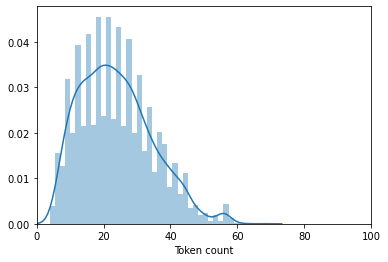

In [7]:
token_lens = []

for txt in df.OutputText:
  tokens = tokenize_input(txt)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [8]:
inputText = Field(init_token="<sos>", eos_token="<eos>", tokenize=tokenize_input, lower=True)
outputText = Field(init_token="<sos>", eos_token="<eos>", tokenize=tokenize_output, lower=True)

In [9]:
fields = {"InputText": ("inputText", inputText), "OutputText": ("outputText", outputText)}

In [10]:
train_data, valid_data = TabularDataset.splits(
    path="data", train="train.json", test="valid.json", format="json", fields=fields
)

test_data = TabularDataset.splits(
    path="data", test="test.json", format="json", fields=fields
)

In [11]:
inputText.build_vocab(train_data, max_size=100000, min_freq=2)
outputText.build_vocab(train_data, max_size=100000, min_freq=2)

In [12]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, inputText):
        src_mask = inputText.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, inputText, outputText):
        src_seq_length, N = inputText.shape
        trg_seq_length, N = outputText.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(inputText) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(outputText) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(inputText)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

In [13]:
# We're ready to define everything we need for training our Seq2Seq model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_model = True
save_model = True

# Training hyperparameters
num_epochs = 1000
learning_rate = 3e-4
batch_size = 32

# Model hyperparameters
src_vocab_size = len(inputText.vocab)
trg_vocab_size = len(outputText.vocab)
embedding_size = 512    # default: 512
num_heads = 8
num_encoder_layers = 3  # 6 in paper
num_decoder_layers = 3
dropout = 0.10
max_len = 100
forward_expansion = 4
src_pad_idx = inputText.vocab.stoi["<pad>"]

# Tensorboard to get nice loss plot
writer = SummaryWriter("runs/loss_plot")
step = 0

In [14]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.inputText),
    device=device,
)

In [15]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

In [18]:
pad_idx = inputText.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)

In [19]:
if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

sentence = "The boy is going to school and he is carrying a big bag."

In [ ]:
src = "I was cutting the wood with a saw."

prediction = process_sentence(model, src, inputText, outputText, device)
prediction = prediction[:-1]  # remove <eos> token

print(prediction)

In [20]:
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    model.eval()
    processed_sentence = process_sentence(
        model, sentence, inputText, outputText, device, max_length=50
    )

    print(f"Predicted sentence: \n {processed_sentence}")
    model.train()
    losses = []

    for batch_idx, batch in enumerate(train_iterator):
        # Get input and targets and get to cuda
        inp_data = batch.inputText.to(device)
        target = batch.outputText.to(device)

        # Forward prop
        output = model(inp_data, target[:-1, :])

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin.
        # Let's also remove the start token while we're at it
        output = output.reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()

        loss = criterion(output, target)
        losses.append(loss.item())

        # Back prop
        loss.backward()
        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        # plot to tensorboard
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1

    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)

[Epoch 0 / 1000]
=> Saving checkpoint
Predicted sentence: 
 ['wheat', 'wonderful', 'barry', 'monroe', 'wonderful', 'express', 'wonderful', 'tet', 'wonderful', 'auditor', 'express', 'express', 'auditor', 'express', 'solo', 'reading', 'liver', 'express', 'wonderful', 'auditor', 'express', 'calming', 'solo', 'reading', 'auditor', 'auditor', 'express', 'good', 'monroe', 'wonderful', 'auditor', 'wonderful', 'profession', 'priceless', 'express', 'good', 'solo', 'express', 'wonderful', 'auditor', 'express', 'wonderful', 'auditor', 'wonderful', 'auditor', 'auditor', 'express', 'wonderful', 'auditor', 'express']
[Epoch 1 / 1000]
=> Saving checkpoint
Predicted sentence: 
 ['the', 'say', 'be', 'go', 'to', 'school', 'and', 'he', 'be', 'not', 'a', '$', 'a', '.', '<eos>']
[Epoch 2 / 1000]
=> Saving checkpoint
Predicted sentence: 
 ['the', 'boy', 'be', 'go', 'to', 'school', 'and', 'he', 'be', 'not', 'a', 'big', 'point', '.', '<eos>']
[Epoch 3 / 1000]
=> Saving checkpoint
Predicted sentence: 
 ['the',

KeyboardInterrupt: 

In [68]:
for ex in valid_data:
    print(vars(ex)["inputText"])
    break

['the', 'deputy', 'prime', 'minister', 'said', 'based', 'on', 'these', 'three', 'principles', ',', 'felda', ',', 'which', 'is', 'now', '50', 'years', 'old', ',', 'would', 'grow', 'and', 'strengthen', 'all', 'its', 'activities', 'from', 'the', 'settlers', 'community', 'level', 'right', 'up', 'to', 'the', 'global', 'level', '.']
